# Chapter 5.6 - Resampling Methods

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

## CV for Regression

In [4]:
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.model_selection import KFold

# Create a regression dataset with 100 samples and 100 features, 10 of which are informative
X, y = datasets.make_regression(n_samples=100, n_features=100, n_informative=10, random_state=42)

# Initialize Ridge regression model with alpha=10 (regularization strength)
estimator = lm.Ridge(alpha=10)

# Initialize KFold cross-validation with 5 splits and shuffle the data
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Set shuffle=True for random splits

# Initialize lists to store R-squared scores for training and testing sets
r2_train, r2_test = list(), list()

# Perform KFold cross-validation
for train, test in cv.split(X):
    estimator.fit(X[train, :], y[train])                                         # Train the model on the training split
    r2_train.append(metrics.r2_score(y[train], estimator.predict(X[train, :])))  # Calculate R2 on training data
    r2_test.append(metrics.r2_score(y[test], estimator.predict(X[test, :])))     # Calculate R2 on test data

# Print the mean R-squared scores for training and testing sets
print("Train r^2: %.2f" % np.mean(r2_train))  # Print average training R2 score
print(" Test r^2: %.2f" % np.mean(r2_test))    # Print average testing R2 score

Train r^2: 0.99
 Test r^2: 0.67


#### Explanation:

`Ridge regression`: This is a linear regression model with L2 regularization. The alpha=10 controls the regularization strength.

`KFold cross-validation`: It splits the dataset into n_splits=5 parts and ensures that each fold is used for testing exactly once while the remaining 4 parts are used for training.

    - shuffle=True: The data is shuffled before being split, ensuring random splitting.
    - random_state=42: A fixed random seed ensures reproducibility of the shuffling.
    
`R-squared (r2) score`: This score measures how well the regression model fits the data. It ranges from negative values to 1, where 1 indicates perfect prediction.

`Mean R-squared`: After training and testing on each split, the mean R2 score is computed and printed to give an overall evaluation of model performance.







    Scikit-learn provides user-friendly function to perform CV:

In [7]:
from sklearn.model_selection import KFold, cross_val_score
import sklearn.linear_model as lm
from sklearn import datasets
import numpy as np

# Generate the dataset
X, y = datasets.make_regression(n_samples=100, n_features=100, n_informative=10, random_state=42)

# Initialize the Ridge regression model
estimator = lm.Ridge(alpha=10)

# Perform cross-validation with default KFold (no shuffle)
scores = cross_val_score(estimator=estimator, X=X, y=y, cv=5)
print("             Test r^2: %.2f" % scores.mean())  # Display the mean R-squared score across the test sets

# Initialize KFold cross-validation with 5 splits, shuffle=True, and a fixed random state
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation using the custom KFold object and compute R-squared scores
scores = cross_val_score(estimator=estimator, X=X, y=y, cv=cv)
print("Test r^2 with shuffle: %.2f" % scores.mean())  # Display the mean R-squared score across the test sets

             Test r^2: 0.73
Test r^2 with shuffle: 0.67


      No shuffle, the model explains 73% of the variance in the data.
    With shuffle, the model explains 67% of the variance in the data.

## CV for Classification

With classification problems it is essential to sample folds where each set contains approximately the same percentage of samples of each target class as the complete set. This is called stratification. In this case, we will use `StratifiedKFold` with is a variation of k-fold which returns stratified folds.

Usually the error function 𝐿() are, at least, the sensitivity and the specificity. However other function could be used.

In [11]:
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

X, y = datasets.make_classification(n_samples=100, n_features=100,     # Generate a classification dataset with 100 samples, 100 features
                                    n_informative=10, random_state=42) # 10 informative features, Random seed set for reproducibility

estimator = lm.LogisticRegression(C=1, solver='lbfgs')                 # Initialize LRRegression with C=1 (regularization) and solver 'lbfgs'
cv = StratifiedKFold(n_splits=5)                                       # Use StratifiedKFold cv with 5 splits (preserving class distribution)

# Lists to store scores by folds (for macro measure only)
recalls_train, recalls_test, acc_test = list(), list(), list()         # Initialize empty lists to store recall (train/test) and accuracy (test) scores

# Or vector of test predictions (for both macro and micro measures, not for training samples)
y_test_pred = np.zeros(len(y))                                         # Create a 0 vector to store test predictions across all folds for micro measures

for train, test in cv.split(X, y):                                     # Loop through each fold (train/test indices) in StratifiedKFold
    estimator.fit(X[train, :], y[train])                               # Train the model on the current training fold
    recalls_train.append(metrics.recall_score(y[train], estimator.predict(X[train, :]), average=None)) # Compute recall for training fold and store it
    recalls_test.append(metrics.recall_score(y[test], estimator.predict(X[test, :]), average=None))    # Compute recall for test fold and store it
    acc_test.append(metrics.accuracy_score(y[test], estimator.predict(X[test, :])))                    # Compute accuracy for the test fold and store it

    # Store test predictions (for micro measures)
    y_test_pred[test] = estimator.predict(X[test, :])                  # Save the test predictions for later evaluation (micro measures)
    
print("=== Macro measures ===")

# Use lists of scores
recalls_train = np.array(recalls_train)                                # Convert training recall scores to a numpy array for easier calculation
recalls_test = np.array(recalls_test)                                  # Convert test recall scores to a numpy array
print("Train SPC:%.2f; SEN:%.2f" % tuple(recalls_train.mean(axis=0)))  # Print mean specificity (SPC) and sensitivity (SEN) for the training folds
print(" Test SPC:%.2f; SEN:%.2f" % tuple(recalls_test.mean(axis=0)), ) # Print mean SPC and SEN for the test folds
print(" Test ACC:%.2f, ballanced ACC:%.2f" %                           # Print test accuracy and balanced accuracy (mean of recalls)
(np.mean(acc_test), recalls_test.mean(axis=1).mean()), "Folds:", acc_test) # Print per-fold test accuracy

# Or use vector to test predictions
acc_test = [metrics.accuracy_score(y[test], y_test_pred[test]) for train, test in cv.split(X, y)] # Recompute accuracy using the stored test predictions
print(" Test ACC:%.2f" % np.mean(acc_test), "Folds:", acc_test)         # Print average test accuracy and accuracy for each fold
print()

print("=== Micro measures ===")

print("Test SPC:%.2f; SEN:%.2f" % tuple(metrics.recall_score(y, y_test_pred, average=None)))# micro-average specificity and sensitivity across all folds
print("Test ACC:%.2f" % metrics.accuracy_score(y, y_test_pred))                             # micro-average accuracy across all test samples

=== Macro measures ===
Train SPC:1.00; SEN:1.00
 Test SPC:0.76; SEN:0.82
 Test ACC:0.79, ballanced ACC:0.79 Folds: [0.9, 0.7, 0.9, 0.7, 0.75]
 Test ACC:0.79 Folds: [0.9, 0.7, 0.9, 0.7, 0.75]

=== Micro measures ===
Test SPC:0.76; SEN:0.82
Test ACC:0.79


#### Key Concepts:

Cross-Validation (StratifiedKFold):

* Splits the data into 5 folds, ensuring that each fold maintains the same class distribution as the overall dataset (stratification).
* The model is trained and evaluated on different folds to assess its performance on unseen data.

Recall (Sensitivity):

* Measures the proportion of actual positives (class 1) correctly identified. It is calculated separately for training and test sets using recall_score.
* Macro-average recalls are calculated per fold and then averaged.

Specificity (SPC):

* Measures the proportion of actual negatives (class 0) correctly identified. In this code, it's also calculated via recall_score, but for class 0.

Accuracy:

* The proportion of correct predictions (both classes) across the test set for each fold. Calculated using accuracy_score.

Macro and Micro Measures:

* Macro: Averaging the metrics (recall, accuracy) for each fold. Gives equal weight to each class.
* Micro: Evaluating metrics by combining predictions across all test samples, rather than averaging per fold.

In [13]:
from sklearn.model_selection import cross_val_score 

# Perform cross-validation on the estimator (Logistic Regression in this case)
scores = cross_val_score(estimator=estimator,   # Use the estimator (model)
                         X=X,                   # Feature matrix
                         y=y,                   # Target vector
                         cv=5)                  # Use 5-fold cross-validation

scores.mean()                                   # Calculate the mean of the cross-validation scores

# Define a custom balanced accuracy scorer
def balanced_acc(estimator, X, y, **kwargs):  
    '''
    Balanced accuracy scorer: Computes the mean recall (balanced accuracy)
    '''
    return metrics.recall_score(y, estimator.predict(X), average=None).mean()  # Compute mean recall across classes

# Perform cross-validation using the custom balanced accuracy scorer
scores = cross_val_score(estimator=estimator,  # Estimator (model)
                         X=X,                  # Feature matrix
                         y=y,                  # Target vector
                         cv=5,                 # 5-fold cross-validation
                         scoring=balanced_acc) # Use custom balanced accuracy scorer

# Print the average balanced accuracy across folds
print("Test ACC:%.2f" % scores.mean())         # Print the mean score

Test ACC:0.79


Note that with Scikit-learn user-friendly function we average the scores’ average obtained on
individual folds which may provide slightly different results that the overall average presented
earlier.

## Parallel Computation with Joblib

In [16]:
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, StratifiedKFold

# Import necessary modules
X, y = datasets.make_classification(n_samples=20,     # Generate a classification dataset with 20 samples
                                    n_features=5,     # 5 features for each sample
                                    n_informative=2,  # 2 informative features (used for class separation)
                                    random_state=42)  # Set random state for reproducibility

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5)  # StratifiedKFold ensures each fold has a proportional number of samples from each class

# Initialize the Logistic Regression estimator
estimator = lm.LogisticRegression(C=1,             # C is the inverse of regularization strength (higher C means less regularization)
                                  solver='lbfgs')  # 'lbfgs' is the optimization algorithm used to minimize the cost function

# Perform cross-validation with the Logistic Regression model
cv_results = cross_validate(estimator,     # The estimator (Logistic Regression) to use
                            X=X,           # Feature matrix
                            y=y,           # Target labels
                            cv=cv,         # Cross-validation strategy (5-fold stratified)
                            n_jobs=5)      # Run the cross-validation in parallel using 5 CPU cores

# Print the mean of the test scores and the individual test scores for each fold
print(np.mean(cv_results['test_score']),   # Print the average test score across all folds
      cv_results['test_score'])            # Print the test scores from each fold

0.8 [0.5 0.5 1.  1.  1. ]


#### Interpretation

These values represent the accuracy scores of the Logistic Regression model on the test set for each of the 5 folds during cross-validation:

* Fold 1: Accuracy = 0.5
* Fold 2: Accuracy = 0.5
* Fold 3: Accuracy = 1.0
* Fold 4: Accuracy = 1.0
* Fold 5: Accuracy = 1.0

Accuracy is calculated as the ratio of correct predictions to the total number of predictions for each fold's test set.

    In the first two folds, the accuracy is lower (0.5), meaning that the model's predictions were only 50% correct.
    In the last three folds, the model achieved perfect accuracy (1.0), predicting all test samples correctly.

Mean Test Score (0.8) = (0.5 + 0.5 + 1.0 + 1.0 + 1.0) / 5 

If we want have full control of the operations performed within each fold (retrieve the models parameters, etc.). We would like to parallelize the folowing sequetial code:

In [19]:
# Initialize the logistic regression model with L2 regularization (default)
estimator = lm.LogisticRegression(C=1, solver='lbfgs')

# Initialize an array to store the test predictions in their original order
y_test_pred_seq = np.zeros(len(y))  # Will hold predictions from each fold in the original order of the dataset

# Initialize an empty list to store the coefficient estimates from each fold
coefs_seq = list()

# Perform cross-validation by splitting the data into training and test sets using the StratifiedKFold object `cv`
for train, test in cv.split(X, y):  # For each train-test split (5 splits in total):
    
    # Extract the training and test data based on the current fold
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]  # Split data into training and testing sets
    
    # Fit the logistic regression model on the current training set
    estimator.fit(X_train, y_train)
    
    # Make predictions on the current test set and store them in `y_test_pred_seq` in the original order
    y_test_pred_seq[test] = estimator.predict(X_test)
    
    # Append the coefficients (model weights) learned during this fold to the `coefs_seq` list
    coefs_seq.append(estimator.coef_)

# Calculate the accuracy scores for each fold by comparing the test set predictions to the true labels
test_accs = [metrics.accuracy_score(y[test], y_test_pred_seq[test]) for train, test in cv.split(X, y)]

# Print the mean accuracy and individual accuracy scores for each fold
print('Mean [accuracy for each fold]')
print(np.mean(test_accs), test_accs)  # Mean accuracy over all folds and individual fold accuracies
print()

# Convert the list of coefficients into a NumPy array for easier manipulation
coefs_cv = np.array(coefs_seq)

# Print all coefficient vectors from each fold
print('Coefficient vectors from each fold')
print(coefs_cv)

# Print the mean of the coefficients (average model weights across folds)
print('\nMeans of the coefficients')
print(coefs_cv.mean(axis=0))  # Calculate the mean of the coefficients across all folds

# Print the standard error of the coefficients (how much the coefficients vary across folds)
print("\nStd Err of the coefficients")
print(coefs_cv.std(axis=0) / np.sqrt(coefs_cv.shape[0]))  # Standard error of the coefficients across folds

Mean [accuracy for each fold]
0.8 [0.5, 0.5, 1.0, 1.0, 1.0]

Coefficient vectors from each fold
[[[-0.87692648  0.62591974  1.18706081 -0.30704161 -0.38030241]]

 [[-0.74649131  0.62146103  1.10152459  0.19812029 -0.40119197]]

 [[-0.96021714  0.51137735  1.12112968  0.08043038 -0.26438637]]

 [[-0.85768977  0.52013118  1.06648343 -0.10983459 -0.29151814]]

 [[-0.89946124  0.51498228  1.08712223 -0.24754495 -0.27908142]]]

Means of the coefficients
[[-0.86815719  0.55877432  1.11266415 -0.07717409 -0.32329606]]

Std Err of the coefficients
[[0.03126917 0.02374501 0.01845607 0.08568738 0.02510189]]


#### Interpretation

These are the learned model coefficients (weights) for each feature from each fold of the cross-validation. Since this is logistic regression, these coefficients represent the influence of each feature on the model's decision. For example:

    The first row ([-0.87692648, 0.62591974, 1.18706081, -0.30704161, -0.38030241]) corresponds to the learned coefficients from the first fold of cross-validation. 
    
    Each subsequent row corresponds to the coefficients learned from the remaining folds.

This represents the average of the coefficients across all the folds of cross-validation. The values show how much each feature contributes to the model's predictions on average across all folds. For example:

    The first feature has an average coefficient of -0.86815719, meaning it generally has a negative influence on the prediction.
    
    The third feature has an average coefficient of 1.11266415, meaning it has a strong positive influence on the prediction.

The standard error measures the variability in the coefficients across the different cross-validation folds. The smaller the standard error, the more consistent the coefficient estimates across the folds. For example:

    The standard error for the third feature is 0.01845607, indicating that the coefficient for this feature is very stable across folds.
    
    The standard error for the fourth feature is 0.08568738, indicating that the coefficient for this feature varies more across folds.

In [21]:
import joblib  
from joblib import Parallel, delayed 
from sklearn.base import is_classifier, clone

def _split_fit_predict(estimator, X, y, train, test):  
    """Fit the estimator on training data and predict on test data."""
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]  # Split data
    estimator.fit(X_train, y_train)                                                # Fit the model on training data
    return [estimator.predict(X_test), estimator.coef_]                            # Return test predictions and coefficients

# Initialize Logistic Regression estimator
estimator = lm.LogisticRegression(C=1, solver='lbfgs')  # Regularized logistic regression

# Set up parallel execution (using 5 jobs)
parallel = Parallel(n_jobs=5)                           # Execute jobs in parallel with 5 processes

# Perform cross-validation in parallel
cv_ret = parallel(
    delayed(_split_fit_predict)(clone(estimator), X, y, train, test)  # Fit and predict in parallel
    for train, test in cv.split(X, y)                                 # Iterate through cross-validation splits
)

# Unpack results into predictions and coefficients
y_test_pred_cv, coefs_cv = zip(*cv_ret)                 # Collect predictions and coefficients for each fold

# Retrieve predictions in the original order
y_test_pred = np.zeros(len(y))  # Initialize an array for storing predictions

for i, (train, test) in enumerate(cv.split(X, y)):      # Iterate through the cross-validation splits
    y_test_pred[test] = y_test_pred_cv[i]               # Assign predictions back in original order

# Calculate accuracy for each test fold
test_accs = [metrics.accuracy_score(y[test], y_test_pred[test]) for train, test in cv.split(X, y)]

# Print mean test accuracy and accuracies for each fold
print(np.mean(test_accs), test_accs)                    # Display average accuracy and individual fold results

0.8 [0.5, 0.5, 1.0, 1.0, 1.0]


#### Test same predictions and same coeficients

In [23]:
# Compare predictions from parallel execution vs sequential execution
if np.all(y_test_pred == y_test_pred_seq):
    print("All predictions match between parallel and sequential executions.")
else:
    print("There are differences in predictions between parallel and sequential executions.")

# Compare coefficients from parallel execution vs sequential execution
if np.allclose(np.array(coefs_cv).squeeze(), np.array(coefs_seq).squeeze()):
    print("All coefficients match between parallel and sequential executions.")
else:
    print("There are differences in coefficients between parallel and sequential executions.")

All predictions match between parallel and sequential executions.
All coefficients match between parallel and sequential executions.


## CV for Model Selection: Setting the Hyper Parameters

In [25]:
from sklearn import datasets
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import KFold

# Dataset generation: Create a synthetic regression dataset
noise_sd = 10                                         # Standard deviation of the noise added to the dataset
X, y, coef = datasets.make_regression(n_samples=50,   # Number of samples
                                      n_features=100, # Number of features (input variables)
                                      noise=noise_sd, # Add Gaussian noise to the target variable y
                                      n_informative=2,# Only 2 features are actually informative
                                      random_state=42,# Random seed for reproducibility
                                      coef=True)      # Return the coefficients used to generate the data

# Compute and display the Signal-to-Noise Ratio (SNR)
# SNR is the ratio between the standard deviation of the signal (X.dot(coef)) and the noise (noise_sd)
print("SNR:", np.std(np.dot(X, coef)) / noise_sd)     # A lower SNR means the data is noisier

SNR: 2.6358469446381614


In [26]:
# Define a parameter grid for hyperparameter tuning (alpha and l1_ratio)
# 'alpha' controls the strength of regularization, and 'l1_ratio' balances between L1 (lasso) and L2 (ridge) regularization
param_grid = {'alpha': 10. ** np.arange(-3, 3),      # alpha values ranging from 0.001 to 100 (log scale)
              'l1_ratio': [.1, .5, .9]}              # l1_ratio values: 0.1 (more ridge), 0.5 (balance), 0.9 (more lasso)

# Wrap the ElasticNet model using GridSearchCV to search for the best combination of alpha and l1_ratio
# ElasticNet is a linear regression model that combines L1 and L2 regularization (lasso + ridge)
model = GridSearchCV(lm.ElasticNet(max_iter=10000),  # ElasticNet with maximum 10,000 iterations for convergence
                     param_grid,                     # Grid of hyperparameters to search
                     cv=5)                           # 5-fold cross-validation to evaluate performance

model.fit(X, y)  # Fit the model to the training data (X, y)

# Calculate and display the R-squared score on the training data
# R-squared represents the proportion of variance explained by the model (closer to 1 is better)
print("Train r2:%.2f" % metrics.r2_score(y, model.predict(X)))  # R-squared score for model performance on training data

# Print the best parameters found by GridSearchCV
# These are the optimal values of alpha and l1_ratio based on cross-validation
print(model.best_params_)

Train r2:0.96
{'alpha': 1.0, 'l1_ratio': 0.9}


In [27]:
# Define K-fold cross-validation with 5 splits, shuffling enabled, and a fixed random seed for reproducibility
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Enable shuffling to use random_state

# Initialize lists to store R-squared scores for training and testing sets, and the selected alpha values
r2_train, r2_test = list(), list()  # Store R-squared scores for training and test sets
alphas = list()                     # Store the best alpha values selected in each fold

# Iterate through each train-test split of the data
for train, test in cv.split(X, y):  # Split the data into training and test sets in each fold
    # Split the data into training and testing sets based on the current fold
    X_train, X_test, y_train, y_test = X[train, :], X[test, :], y[train], y[test]
    
    # Fit the ElasticNet model on the training data
    model.fit(X_train, y_train)
    
    # Calculate R-squared scores for both the training and testing sets
    r2_test.append(metrics.r2_score(y_test, model.predict(X_test)))     # R-squared score for the test set
    r2_train.append(metrics.r2_score(y_train, model.predict(X_train)))  # R-squared score for the training set
    
    # Append the best alpha (regularization parameter) selected by the GridSearchCV model in each fold
    alphas.append(model.best_params_)

# Print the mean R-squared score for the training data across all folds
print("Train r^2:%.2f" % np.mean(r2_train))  # Calculate and display the average R-squared score for the training set

# Print the mean R-squared score for the testing data across all folds
print(" Test r^2:%.2f" % np.mean(r2_test))   # Calculate and display the average R-squared score for the test set

# Print the selected alpha values (best regularization parameters) from each fold
print("\nSelected alphas:", alphas)          # Display the best alpha values selected by GridSearchCV in each fold

Train r^2:0.98
 Test r^2:0.75

Selected alphas: [{'alpha': 1.0, 'l1_ratio': 0.9}, {'alpha': 0.001, 'l1_ratio': 0.9}, {'alpha': 1.0, 'l1_ratio': 0.9}, {'alpha': 1.0, 'l1_ratio': 0.9}, {'alpha': 0.1, 'l1_ratio': 0.9}]


#### Interpretation

`Train R²= 0.98`: the model explains 98% of the variance in the target variable (y) for the training set.

`Test R²= 0.75`: the model explains 75% of the variance in the target variable for the test set.


Selected Alphas:

* Alpha: Controls the strength of regularization. Higher values of alpha apply stronger regularization, which helps in preventing overfitting by penalizing large coefficients.

* l1_ratio: Controls the mix between L1 and L2 regularization. A value of 0.9 means the model is mostly using L1 regularization (which tends to shrink some coefficients to exactly zero, promoting sparsity), but also includes some L2 regularization (which tends to shrink coefficients without forcing them to zero).

The model performed cross-validation across different folds, and for each fold, a different set of best parameters (alpha, l1_ratio) was chosen. The selected alphas across the 5 folds are:

    {'alpha': 1.0, 'l1_ratio': 0.9} (chosen in 3 folds)
    {'alpha': 0.001, 'l1_ratio': 0.9} (chosen in 1 fold)
    {'alpha': 0.1, 'l1_ratio': 0.9} (chosen in 1 fold)

In [29]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation to evaluate the model's performance
scores = cross_val_score(estimator=model,  # The model to be evaluated, in this case, 'model' (e.g., ElasticNet, Ridge)
                         X=X,              # The feature matrix (input data) used for training and evaluation
                         y=y,              # The target vector (output data) corresponding to the feature matrix
                         cv=cv)            # The cross-validation splitting strategy (e.g., KFold, StratifiedKFold)

# Print the average R-squared score across all the cross-validation folds
print("Test r^2: %.2f" % scores.mean())     # Format the mean R² score and display it

Test r^2: 0.75


On average, 75% of the variance in the target variable y can be explained by the model when evaluated on the test data using cross-validation.

In [31]:
from sklearn import datasets               
import sklearn.linear_model as lm         
import sklearn.metrics as metrics         
from sklearn.model_selection import cross_val_score 

# Dataset generation
X, y, coef = datasets.make_regression(n_samples=50,        # Generate a regression dataset with 50 samples
                                      n_features=100,      # with 100 features (predictors)
                                      noise=10,            # Add noise to the data (standard deviation of 10)
                                      n_informative=2,     # Only 2 of the features are truly informative
                                      random_state=42,     # Ensure reproducibility of results with a fixed random seed
                                      coef=True)           # Return the true coefficients used to generate the data

# Ridge Regression (L2 Regularization)
print("=== Ridge (L2 penalty) ===")
model = lm.RidgeCV(cv=3)                                   # Use Ridge regression with built-in cross-validation
                                                           # RidgeCV automatically chooses the best alpha (regularization strength) 
                                                           # from a range of values

# Perform 5-fold cross-validation
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)  # Perform 5-fold cross-validation to evaluate the model
print("Test r^2: %.2f" % scores.mean())                    # Print the average R-squared score from the 5 cross-validation runs
print()

# Lasso Regression (L1 Regularization)
print("=== Lasso (L1 penalty) ===")
model = lm.LassoCV(n_jobs=-1, cv=3)                        # Use Lasso regression with built-in cross-validation
                                                           # LassoCV automatically selects the best alpha for L1 regularization

# Perform 5-fold cross-validation
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)  # Perform 5-fold cross-validation to evaluate the model
print("Test r^2: %.2f" % scores.mean())                    # Print the average R-squared score from the 5 cross-validation runs
print()

# ElasticNet Regression (Combination of L1 and L2 Regularization)
print("=== ElasticNet (L1 penalty) ===")
model = lm.ElasticNetCV(l1_ratio=[.1, .5, .9], n_jobs=-1, cv=3)  # Use ElasticNet regression with cross-validation
                                                                 # l1_ratio=[.1, .5, .9] tests multiple L1/L2 combinations
                                                                 # ElasticNetCV automatically chooses the best alpha and l1_ratio

# Perform 5-fold cross-validation
scores = cross_val_score(estimator=model, X=X, y=y, cv=5)  # Perform 5-fold cross-validation to evaluate the model
print("Test r^2: %.2f" % scores.mean())                    # Print the average R-squared score from the 5 cross-validation runs

=== Ridge (L2 penalty) ===
Test r^2: 0.16

=== Lasso (L1 penalty) ===
Test r^2: 0.74

=== ElasticNet (L1 penalty) ===
Test r^2: 0.58


#### Interpretation

**The Ridge regression** model with L2 regularization performed poorly in this case, as it explains only 16% of the variance in the target variable (R² = 0.16). This could indicate that Ridge regression might not be the best choice for this dataset, especially since Ridge tends to spread the effect of regularization over all features, even those that may not be very informative.

**The Lasso regression** model performs significantly better, explaining 74% of the variance in the target variable. Lasso (L1 regularization) helps with feature selection by driving some of the less important coefficients to zero. This suggests that many of the features in this dataset are irrelevant, and Lasso is better at isolating the truly important ones, which leads to improved predictive performance.

**ElasticNet**, which combines both L1 and L2 regularization, performs moderately well with an R² score of 0.58. This result is better than Ridge but worse than Lasso. This may suggest that the combination of L1 and L2 regularization is not as effective as pure L1 regularization for this particular dataset, where Lasso's ability to select a sparse set of important features is more beneficial.

#### Conclusion

**Lasso** clearly outperforms both Ridge and ElasticNet on this dataset, suggesting that the dataset likely has a few highly informative features, while many others contribute little to the prediction task. Lasso's feature selection capability (driving some coefficients to zero) is likely beneficial here. **Ridge** fails to perform well, likely because it doesn't perform feature selection and includes all features in its model, leading to lower predictive performance. **ElasticNet** strikes a balance between Ridge and Lasso, but in this case, the pure L1 regularization of Lasso works better.

## Classification Models with Built-in Cross-Validation

In [34]:
from sklearn import datasets  
import sklearn.linear_model as lm  
import sklearn.metrics as metrics 
from sklearn.model_selection import cross_val_score 

# Generate a synthetic classification dataset
X, y = datasets.make_classification(n_samples=100,    # 100 samples
                                    n_features=100,   # 100 features in total
                                    n_informative=10, # 10 informative features
                                    random_state=42)  # Ensure reproducibility with a fixed seed

# Define a custom balanced accuracy scorer function
def balanced_acc(estimator, X, y, **kwargs):
    '''
    Balanced accuracy scorer function that computes the mean recall score for each class.
    This function is used as a custom scoring metric for evaluating the classifier's performance.
    '''
    return metrics.recall_score(y, estimator.predict(X), average=None).mean()  # Compute mean recall for each class

print("=== Logistic Ridge (L2 penalty) ===")

# Initialize a Logistic Regression model with cross-validation
model = lm.LogisticRegressionCV(class_weight='balanced',  # Set 'balanced' class weights to handle imbalanced data
                                scoring=balanced_acc,     # Use the custom balanced accuracy scorer function
                                n_jobs=-1,                # Use all available cores for parallel processing
                                cv=3)                     # Perform 3-fold cross-validation

# Perform cross-validation using 5-fold cross-validation
scores = cross_val_score(estimator=model,  # The Logistic Regression model with CV
                         X=X,              # Feature matrix
                         y=y,              # Target vector
                         cv=5)             # 5-fold cross-validation

# Print the mean test balanced accuracy score across all folds
print("Test ACC: %.2f" % scores.mean())    # Display the average accuracy over the 5 folds

=== Logistic Ridge (L2 penalty) ===
Test ACC: 0.76


## Random Permutations

A permutation test is a type of non-parametric randomization test in which the null distribution of a test statistic is estimated by randomly permuting the observations.

Permutation tests are highly attractive because they make no assumptions other than that th observations are independent and identically distributed under the null hypothesis
.
1. Compute a observed statistic 𝑡𝑜𝑏𝑠 on the data.
2. Use randomization to compute the distribution of 𝑡 under the null hypothesis: Perform 𝑁
random permutation of the data. For each sample of permuted data, 𝑖 the data com ute
the statistic 𝑡𝑖. This procedure provides the distribution of 𝑡 under the null hypothesis 𝐻0:
𝑃 (𝑡|𝐻0)
3. Compute the p-value = 𝑃 (𝑡 > 𝑡𝑜𝑏𝑠|𝐻0) |{𝑡𝑖 > 𝑡𝑜𝑏𝑠}|, where 𝑡𝑖’s include 𝑡𝑜𝑏𝑠.

### Example with a Correlation (the statistic is the correlation)

Permutation two-tailed p-value = 0.06959. 
Pearson test p-value = 0.07355



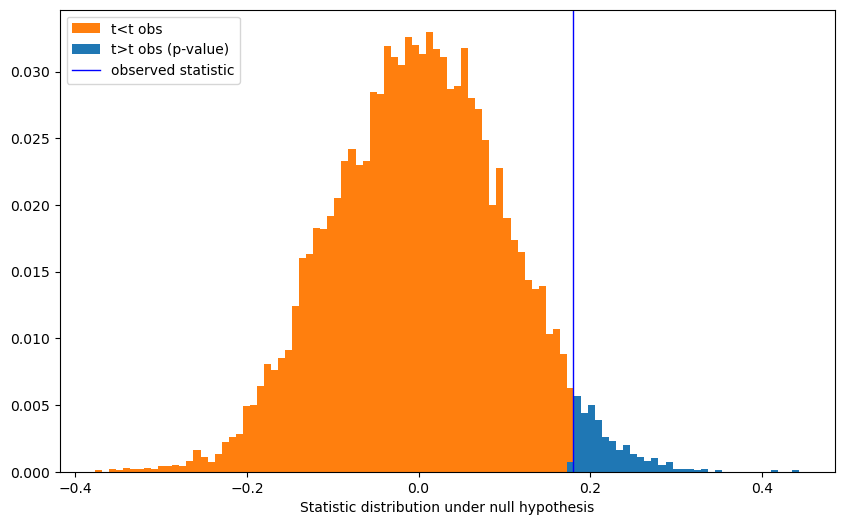

In [37]:
import scipy.stats as stats  # Import statistical functions module for correlation tests

# Generate random data
np.random.seed(42)                                   # Fix the seed for reproducibility
x = np.random.normal(loc=10, scale=1, size=100)      # Generate 100 samples from a normal distribution with mean=10 and std=1
y = x + np.random.normal(loc=-3, scale=3, size=100)  # Generate 'y' as 'x' plus noise (mean=-3, std=3). Signal-to-noise ratio (snr) = 1/2

# Permutation test: simulate the null hypothesis
nperm = 10000                       # Number of permutations
perms = np.zeros(nperm + 1)         # Array to store correlation values under the null hypothesis
perms[0] = np.corrcoef(x, y)[0, 1]  # Compute the observed correlation coefficient between 'x' and 'y'
for i in range(1, nperm):
    perms[i] = np.corrcoef(np.random.permutation(x), y)[0, 1]  # Permute 'x' and calculate correlation under the null hypothesis

# Plotting the results of the permutation test
plt.figure(figsize=(10, 6))                                    # Set figure size to make the graph larger
weights = np.ones(perms.shape[0]) / perms.shape[0]             # Set equal weights for the histogram bins

plt.hist([perms[perms >= perms[0]], perms],                    # Plot the histogram of the correlation distribution
         histtype='stepfilled',                                # Use filled steps for the histogram style
         bins=100,                                             # Set the number of bins to 100
         label=["t>t obs (p-value)", "t<t obs"],               # Labels for areas representing p-value
         weights=[weights[perms >= perms[0]], weights])        # Apply weights to the histogram 

plt.xlabel("Statistic distribution under null hypothesis")                      # Label the x-axis
plt.axvline(x=perms[0], color='blue', linewidth=1, label="observed statistic")  # Draw a vertical line for the observed statistic
_ = plt.legend(loc="upper left")                                                # Add a legend in the upper left corner of the plot

# Compute the empirical one-tailed p-value from the permutation test
pval_perm = np.sum(perms >= perms[0]) / perms.shape[0]  # Count how often the permuted correlations are greater than or equal to the observed value

# Compare with the p-value from Pearson's correlation test
_, pval_test = stats.pearsonr(x, y)  # Perform Pearson correlation test on the data 'x' and 'y'
print("Permutation two-tailed p-value = %.5f. \nPearson test p-value = %.5f" % (2*pval_perm, pval_test))  # Display the permutation p-value and 
print()                                                                                                   # the Pearson p-value

#### Concepts Explained:

Permutation Test:

- This is a non-parametric method to estimate the distribution of a test statistic under the null hypothesis. In this code, the null hypothesis assumes no relationship between x and y.
The perms array stores the correlation coefficients between permuted versions of x and y. The observed correlation is stored in perms[0].

Null Hypothesis:

- The permutation of x while keeping y fixed simulates the null hypothesis that there is no association between x and y.

Empirical p-value:

- The p-value is computed as the proportion of permutations where the correlation coefficient is greater than or equal to the observed value (perms[0]). This represents how likely the observed correlation is under the null hypothesis.

Pearson’s Correlation:

- The code also calculates the p-value from the Pearson correlation test using scipy.stats.pearsonr. This provides a parametric test for correlation based on assumptions of normality.

Visualization:

- The histogram shows the distribution of correlation values under the null hypothesis. The blue vertical line marks the observed correlation statistic, and the area to the right represents the empirical p-value.

Two-Tailed Test:

- The final p-value from the permutation test is multiplied by 2 to account for a two-tailed test, even though only the right tail is shown.

#### Interpretation of the Output:

The code compares the p-value obtained from the permutation test to the p-value from Pearson’s correlation test. If both p-values are low, it suggests that the observed correlation is significantly different from what would be expected under the null hypothesis.

The final p-value from the permutation test is multiplied by 2 to account for a two-tailed test, even though only the right tail is shown.

## Exercise

Given the logistic regression presented above and its validation given a 5 folds CV.

1. Compute the p-value associated with the prediction accuracy using a permutation test.
2. Compute the p-value associated with the prediction accuracy using a parametric test.

Observed Accuracy: 0.7900
Permutation test p-value: 0.0000


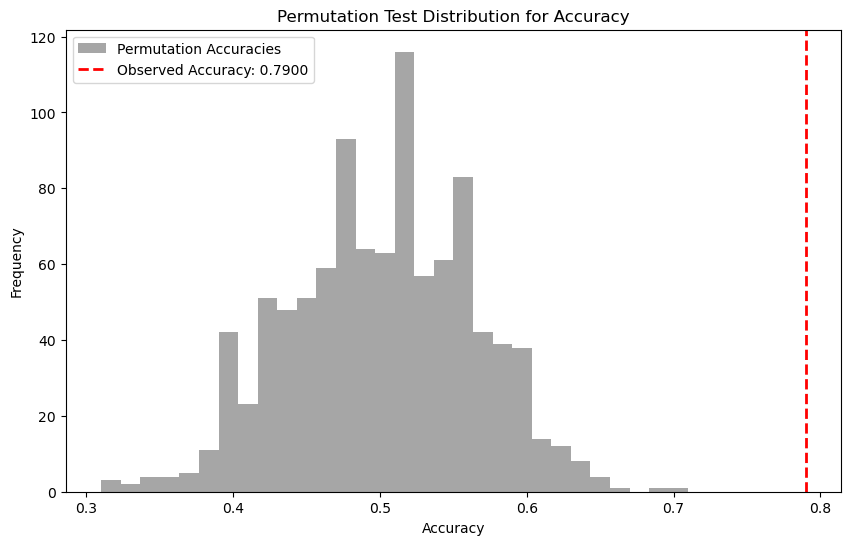

Parametric binomial test p-value: 0.0000


In [41]:
import numpy as np  
from sklearn.model_selection import cross_val_score, StratifiedKFold  
from sklearn.linear_model import LogisticRegression 
from sklearn.datasets import make_classification  
from scipy import stats 
import matplotlib.pyplot as plt 

# Step 1: Create a dataset
np.random.seed(42)  # Set seed for reproducibility
X, y = make_classification(n_samples=100, n_features=20,         # Generate a classification dataset with 100 samples, 20 features
                           n_informative=5, random_state=42)     # 5 informative features, random seed for reproducibility

# Step 2: Logistic Regression with 5-fold cross-validation
model = LogisticRegression(solver='lbfgs', max_iter=1000)        # Initialize logistic regression model with 'lbfgs' solver and 1000 iterations
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold stratified cross-validation with shuffled data

# Compute accuracy using cross-validation
accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  # Perform cross-validation and calculate accuracy scores
observed_accuracy = accuracies.mean()                                 # Compute mean accuracy across folds
print(f"Observed Accuracy: {observed_accuracy:.4f}")                  # Print the observed accuracy

# Exercise 1: Permutation Test

# Step 3: Permutation test to calculate empirical p-value for accuracy
n_permutations = 1000                       # Number of permutations for null hypothesis simulation
perm_accuracies = np.zeros(n_permutations)  # Initialize array to store accuracies from permuted labels

for i in range(n_permutations):                                               # Loop through each permutation
    y_permuted = np.random.permutation(y)                                     # Shuffle labels to break association between X and y
    perm_accuracies[i] = cross_val_score(model, X, y_permuted,                # Perform cross-validation with permuted labels
                                         cv=cv, scoring='accuracy').mean()    # Store mean accuracy from permutation

# Compute empirical p-value
p_value_perm = np.sum(perm_accuracies >= observed_accuracy) / n_permutations  # Calc. p-value based on how often permuted accuracy >= observed accuracy
print(f"Permutation test p-value: {p_value_perm:.4f}")                        # Print permutation test p-value

# Plot permutation distribution
plt.figure(figsize=(10, 6))                                                                  # Set figure size for plot
plt.hist(perm_accuracies, bins=30, alpha=0.7, label="Permutation Accuracies", color='grey')  # Plot histogram of permutation accuracies
plt.axvline(observed_accuracy,        # Add a vertical line at the observed accuracy value
            color='red',              # Set the line color to red
            linestyle='--',           # Use a dashed line style
            linewidth=2,              # Set the line width to 2 for better visibility
            label=f"Observed Accuracy: {observed_accuracy:.4f}")  # Label the line with the observed accuracy value formatted to 4 decimal places

plt.xlabel("Accuracy")      # Label for x-axis
plt.ylabel("Frequency")     # Label for y-axis
plt.title("Permutation Test Distribution for Accuracy")           # Set plot title
plt.legend()                # Show legend
plt.show()                  # Display the plot

# Exercise 2: Parametric Test

# Step 4: Parametric test (Binomial Test)
# Assuming the null hypothesis: accuracy = 50% (random guessing)
n_samples = len(y)                                                # Get the total number of samples in the dataset
observed_correct_predictions = int(observed_accuracy * n_samples) # Calculate the number of correct predictions based on observed accuracy
p_value_param = stats.binomtest(observed_correct_predictions,     # Perform binomial test to compare observed correct predictions to chance level (50%)
                                 n=n_samples, p=0.5,              # Null hypothesis assumes accuracy of 50%
                                 alternative='greater')           # One-tailed test to see if accuracy is greater than 50%

# Access p-value from the BinomTestResult object
print(f"Parametric binomial test p-value: {p_value_param.pvalue:.4f}")   # Print parametric test p-value

#### Interpretation

The results and graph you presented show the outcome of two statistical tests — **Permutation Test** and **Parametric Binomial Test** — both used to determine if the observed classification accuracy (79%) is significantly higher than the accuracy expected by chance (50%).

1. `Observed Accuracy: 0.7900`

- It means that the logistic regression classifier correctly predicted the class labels approximately 79% of the time.
 
2. `Permutation Test p-value: 0.0000`

- The **Permutation Test** assesses how often an accuracy equal to or greater than the observed accuracy (0.79) can be achieved by random chance when the labels are randomly shuffled.

- In this case, none of the 1000 permutations resulted in an accuracy equal to or higher than 0.79. This results in a p-value of nearly zero (0.0000), meaning the observed accuracy is highly unlikely to be the result of chance, providing strong evidence that the model's accuracy is significantly better than random guessing.

3. `Parametric Binomial Test p-value: 0.0000`

- The Parametric Binomial Test assumes that under the null hypothesis, the model's accuracy is at chance level (50%). This test calculates the likelihood of getting the observed number of correct predictions (79%) or more by random chance if the actual accuracy is 50%.

- The resulting p-value is also very close to zero (0.0000), reinforcing the conclusion that the observed accuracy is significantly better than random chance.

#### Graph Explanation:

Histogram of Permutation Accuracies:

- The gray bars represent the distribution of accuracies obtained by randomly permuting the labels and performing cross-validation. The majority of these permutation accuracies fall around 0.4 to 0.6, indicating that the accuracy of a random classifier would hover around these values.

Red Line for Observed Accuracy:

- The vertical red dashed line represents the observed accuracy (0.79). As you can see, none of the permuted datasets achieved an accuracy close to 0.79, which visually illustrates why the permutation test p-value is close to 0.

#### Conclusion:
Both the permutation test and the parametric binomial test strongly suggest that the observed accuracy (79%) is statistically significant and unlikely to have occurred by chance. This means the model is effectively learning to classify the data and is not simply making random guesses.

# Bootstrapping

Bootstrapping is a random sampling with replacement strategy which provides an nonparametric method to assess the variability of performances scores such standard errors or *confidence intervals*.
    
A great advantage of bootstrap is its simplicity. It is a straightforward way to derive estimates of standard errors and confidence intervals for complex estimators of complex parameters of the distribution, such as percentile points, proportions, odds ratio, and correlation coefficients.

1. Perform 𝐵 sampling, with replacement, of the dataset.
2. For each sample 𝑖 fit the model and compute the scores.
3. Assess standard errors and confidence intervals of scores using the scores obtained on the 𝐵 resampled dataset.

In [47]:
import numpy as np
from sklearn import datasets
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import pandas as pd

# Define dataset parameters
n_features = 5          # Number of features (5 features in the dataset)
n_features_info = 2     # Number of informative features (only 2 out of 5 are informative)
n_samples = 100         # Number of samples (100 data points)

# Generate random dataset
X = np.random.randn(n_samples, n_features)  # Generate random feature matrix with normal distribution
beta = np.zeros(n_features)                 # Initialize coefficients (beta) as zero
beta[:n_features_info] = 1                  # Set informative features (first two) to 1
Xbeta = np.dot(X, beta)                     # Compute linear combination of X and beta (signal)
eps = np.random.randn(n_samples)            # Generate random noise (epsilon)
y = Xbeta + eps                             # Compute target values as signal + noise

# Fit model on all data (!! risk of overfit)
model = lm.RidgeCV()                        # Ridge regression with cross-validation to select alpha
model.fit(X, y)                             # Fit the model to the entire dataset (risk of overfitting)

print("Coefficients on all data:")          # Display the coefficients learned from the entire dataset
print(model.coef_)

# Bootstrap loop
nboot = 100                                         # Number of bootstrap iterations (should be at least 1000 for better results)
scores_names = ["r2"]                               # We are interested in R-squared score
scores_boot = np.zeros((nboot, len(scores_names)))  # Initialize array to store R-squared scores for each bootstrap
coefs_boot = np.zeros((nboot, X.shape[1]))          # Initialize array to store coefficients for each bootstrap
orig_all = np.arange(X.shape[0])                    # Create an array of indices for the original dataset

for boot_i in range(nboot):                                                 # Perform bootstrap iterations
    boot_tr = np.random.choice(orig_all, size=len(orig_all), replace=True)  # Sample indices with replacement
    boot_te = np.setdiff1d(orig_all, boot_tr, assume_unique=False)          # Test set indices (not in the training set)
    Xtr, ytr = X[boot_tr, :], y[boot_tr]                                    # Training data from bootstrap sample
    Xte, yte = X[boot_te, :], y[boot_te]                                    # Test data from non-sampled indices
    model.fit(Xtr, ytr)                                                     # Fit model on the bootstrap training set
    y_pred = model.predict(Xte).ravel()                                     # Predict on the test set
    scores_boot[boot_i, :] = metrics.r2_score(yte, y_pred)                  # Store the R-squared score for this bootstrap
    coefs_boot[boot_i, :] = model.coef_                                     # Store the coefficients for this bootstrap

# Compute Mean, SE, CI
scores_boot = pd.DataFrame(scores_boot, columns=scores_names)               # Convert R-squared scores to DataFrame
scores_stat = scores_boot.describe(percentiles=[.025, .5, .975])            # Compute percentiles (2.5%, 50%, and 97.5%)

# Print R-squared statistics: mean, standard error, and confidence intervals (95% CI)
print("\nR-squared: Mean=%.2f, SE=%.2f, CI=(%.2f %.2f)" % 
      tuple(scores_stat.loc[["mean", "std", "2.5%", "97.5%"], "r2"]))       # Mean, Std, and 95% confidence interval

# Coefficients analysis
coefs_boot = pd.DataFrame(coefs_boot)                                       # Convert coefficients to DataFrame
coefs_stat = coefs_boot.describe(percentiles=[.025, .5, .975])              # Compute percentiles for coefficients (2.5%, 50%, 97.5%)

print("\nCoefficients distribution:")                                        # Print coefficient statistics
print(coefs_stat)

Coefficients on all data:
[ 0.70103901  1.06311058  0.06684312 -0.08371484  0.18076706]

R-squared: Mean=0.58, SE=0.11, CI=(0.39 0.75)

Coefficients distribution:
                0           1           2           3           4
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     0.688011    1.045577    0.074811   -0.082345    0.177704
std      0.118569    0.095599    0.106067    0.078052    0.120496
min      0.365485    0.715317   -0.219959   -0.377492   -0.115183
2.5%     0.414031    0.874497   -0.108586   -0.214639   -0.059820
50%      0.686023    1.046438    0.076616   -0.076997    0.171381
97.5%    0.875860    1.223287    0.301039    0.045398    0.404360
max      0.919940    1.299352    0.351070    0.092107    0.487630


#### Interpretation

`Coefficients on all data`:

The coefficients represent the weight each feature contributes to the prediction. Here's what the values indicate:

- The first two coefficients (0.9536, 0.8813) are the most significant because, as per the data generation process, we know that the first two features are informative features. The model is assigning strong weights to these features.

- The last three coefficients (0.0438, 0.0838, -0.0736) are closer to zero, indicating that these features are less informative or provide minimal contribution to the prediction. This makes sense since only two features are actually informative in the dataset.

`R-squared: Mean=0.41, SE=0.14, CI=(0.09 0.58)`:

- An R-squared value of 0.41 means that, on average, 41% of the variance in the target variable is explained by the model. This is a moderate fit—better than random, but far from perfect.

- SE (Standard Error): The standard error of 0.14 reflects the variability of the R-squared values across the 100 bootstrap iterations. The higher the SE, the more variability in the performance of the model across different samples.

- Confidence Interval (CI): The 95% confidence interval of the R-squared values is (0.09, 0.58), meaning that the true R-squared is likely to lie within this range. The wide confidence interval shows that the model's performance varies considerably across different bootstrapped samples. The lower bound (0.09) suggests that the model could perform poorly on some samples.

`Coefficients distribution`:

This table provides statistics on the distribution of the coefficients across the 100 bootstrap iterations.

- Percentiles (2.5% and 97.5%): These are the boundaries for the 95% confidence interval for each coefficient. For instance, the first coefficient's 95% CI is (0.7102, 1.2447), meaning the true value of this coefficient is likely within this range. Similarly, for the other features, their CIs suggest a much larger variation for less important features.